<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/ML-Manuel/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Setup

In [5]:
!git clone -b ML-Manuel https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 767, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 767 (delta 72), reused 27 (delta 27), pack-reused 649 (from 4)
Receiving objects: 100% (767/767), 84.53 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (398/398), done.
/content/DATCapstone/data/DATCapstone/data


In [2]:
!pip install pytorch-lightning
!pip install pytorch-forecasting

# TFT

## Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE
import os
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile
from pytorch_forecasting.data.encoders import NaNLabelEncoder

In [ ]:
# Extract and load the dataset
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

In [ ]:
# Check if GPU is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

CUDA available: False
Using CPU


## Data Exploration

In [ ]:
# Display basic info about the dataset
print(f"Original dataframe shape: {df.shape}")

print("\nFirst few rows:")
print(df.head())

print("\nUnique tickers:")
print(df['Ticker'].unique())
print(f"Number of unique tickers: {df['Ticker'].nunique()}")

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

Original dataframe shape: (8103, 817)

First few rows:
         Date       Open       High        Low      Close    Volume  \
0  2021-06-01  75.393341  75.630189  74.351213  75.383865  10485300   
1  2021-06-02  75.507015  76.672309  75.327016  76.047028  12249300   
2  2021-06-03  75.601763  77.174428  75.459653  76.823891  12038700   
3  2021-06-04  77.136525  79.542898  77.089160  78.529190  14502900   
4  2021-06-07  78.576573  79.817653  78.491304  79.523964  10445600   

   Dividends  Stock Splits  GDP (Billions USD)  Unemployment Rate (%)  ...  \
0        0.0           0.0           23368.861                    5.9  ...   
1        0.0           0.0           23368.861                    5.9  ...   
2        0.0           0.0           23368.861                    5.9  ...   
3        0.0           0.0           23368.861                    5.9  ...   
4        0.0           0.0           23368.861                    5.9  ...   

   emb_763  emb_764  emb_765  emb_766  emb_767  T

## Data Preparation

In [ ]:
# Remove lag features since TFT will handle time dependencies
lag_columns = [col for col in df.columns if '_lag' in col]
print(f"\nRemoving {len(lag_columns)} lag columns from the dataset")
df_no_lag = df.drop(columns=lag_columns)

# Handle embedding columns - Either keep them or use PCA to reduce dimensionality
# Identify embedding columns
emb_columns = [col for col in df_no_lag.columns if col.startswith('emb_')]
print(f"\nFound {len(emb_columns)} embedding columns")

# Option 1: Remove embedding columns since they might be too many for TFT
df_no_emb = df_no_lag.drop(columns=emb_columns)

# We'll work with the version without embeddings for simplicity
df_processed = df_no_emb


Removing 0 lag columns from the dataset

Found 768 embedding columns


In [ ]:
# Select target and features for the model
target = 'Close'  # Or could be 'Close' , 'Target_1day', 'Target_1week', 'Target_1month', 'Target_1year'

# Select relevant features for prediction
# Exclude Date, target variables, and other non-predictive columns
exclude_columns = ['Date'] + [col for col in df_processed.columns if col.startswith('Target_')]
if target not in exclude_columns:
    exclude_columns.append(target)
features = [col for col in df_processed.columns if col not in exclude_columns]
print(f"\nUsing {len(features)} features for prediction")


Using 43 features for prediction


In [ ]:
# Create time index for TFT
df_processed['time_idx'] = df_processed.groupby('Ticker')['Date'].rank(method='dense').astype(int) - 1

# Verify time_idx is properly set for each ticker
for ticker in df_processed['Ticker'].unique():
    ticker_data = df_processed[df_processed['Ticker'] == ticker]
    print(f"{ticker}: time_idx from {ticker_data['time_idx'].min()} to {ticker_data['time_idx'].max()}")

# Set parameters for prediction
# If predicting Target_1day, max_prediction_length=1
# If predicting Target_1week, max_prediction_length=5 (assuming 5 trading days)
# If predicting Target_1month, max_prediction_length=20
max_prediction_length = 1  # Adjust based on your prediction horizon
max_encoder_length = 30    # Use 30 days of history for prediction

ORCL: time_idx from 0 to 922
MSFT: time_idx from 0 to 901
AAPL: time_idx from 0 to 837
AVGO: time_idx from 0 to 815
AMD: time_idx from 0 to 773
AMZN: time_idx from 0 to 773
GOOGL: time_idx from 0 to 773
META: time_idx from 0 to 773
TSLA: time_idx from 0 to 773
NVDA: time_idx from 0 to 753


## Training Setup

In [ ]:
# Create a training dataset - Use the last 20% of the data for testing
val_cutoff = df_processed['time_idx'].max() - max_prediction_length
cutoffs = {}
for ticker in df_processed['Ticker'].unique():
    ticker_data = df_processed[df_processed['Ticker'] == ticker]
    cutoffs[ticker] = ticker_data['time_idx'].max() * 0.8

df_processed['is_train'] = True
for ticker, cutoff in cutoffs.items():
    df_processed.loc[(df_processed['Ticker'] == ticker) &
                    (df_processed['time_idx'] > cutoff), 'is_train'] = False

In [ ]:
# Check which columns have missing values
missing_columns = df_processed.isna().sum()
print("\nColumns with missing values:")
print(missing_columns[missing_columns > 0].sort_values(ascending=False))

# Check for infinite values
df_processed = df_processed.replace([np.inf, -np.inf], np.nan)

# Handle missing values in Inventory specifically (since that's causing the error)
if 'Inventory' in df_processed.columns:
    # For each ticker, fill missing Inventory values with median (or 0 if median is NaN)
    for ticker in df_processed['Ticker'].unique():
        ticker_mask = df_processed['Ticker'] == ticker
        ticker_inventory_median = df_processed.loc[ticker_mask, 'Inventory'].median()
        if pd.isna(ticker_inventory_median):
            ticker_inventory_median = 0
        df_processed.loc[ticker_mask, 'Inventory'] = df_processed.loc[ticker_mask, 'Inventory'].fillna(ticker_inventory_median)


Columns with missing values:
neutral                        5378
negative                       5378
vote                           5378
positive                       5378
Target_1year                   2500
Inventory                      1697
Repurchase Of Capital Stock     774
Long Term Debt                  252
Target_1month                   200
Target_1week                     50
Target_1day                      10
dtype: int64


In [ ]:
# Check all features for missing values and fill appropriately
for feature in features:
    if df_processed[feature].isna().sum() > 0:
        print(f"Filling missing values in {feature}")
        # Fill by ticker
        for ticker in df_processed['Ticker'].unique():
            ticker_mask = df_processed['Ticker'] == ticker
            feature_median = df_processed.loc[ticker_mask, feature].median()
            if pd.isna(feature_median):  # If median is NaN (all values are NaN)
                feature_median = 0
            df_processed.loc[ticker_mask, feature] = df_processed.loc[ticker_mask, feature].fillna(feature_median)

# Verify all missing values are fixed
remaining_missing = df_processed[features].isna().sum()
if remaining_missing.sum() > 0:
    print("Warning: There are still missing values:")
    print(remaining_missing[remaining_missing > 0])
else:
    print("All missing values have been handled.")

Filling missing values in Long Term Debt
Filling missing values in Repurchase Of Capital Stock
Filling missing values in vote
Filling missing values in negative
Filling missing values in neutral
Filling missing values in positive
All missing values have been handled.


## Create TimeSeriesDataSets

In [ ]:
# Reduced feature set for simplicity
reduced_features = features[:20]  # Use only the first 20 features to simplify

# Create training dataset
training = TimeSeriesDataSet(
    data=df_processed[df_processed['is_train']],
    time_idx="time_idx",
    target=target,
    group_ids=["Ticker"],
    min_encoder_length=15,  # Reduced from 30
    max_encoder_length=15,  # Reduced from 30
    min_prediction_length=1,
    max_prediction_length=1,
    static_categoricals=["Ticker"],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=reduced_features,  # Use reduced feature set
    target_normalizer=GroupNormalizer(
        groups=["Ticker"], transformation="softplus"
    ),
    categorical_encoders={
        "Ticker": NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [ ]:
# Verify there are no lag features in the data
print("Lag feature verification:")
lag_features = [col for col in df.columns if '_lag' in col]
print(f"Number of lag features in original dataframe: {len(lag_features)}")
if len(lag_features) == 0:
    print("No lag features found in dataframe. These will be handled by TFT automatically.")
else:
    print("Lag features found in dataframe. Consider removing them to let TFT handle temporal dependencies.")
    print(f"First few lag features: {lag_features[:5]}")

Lag feature verification:
Number of lag features in original dataframe: 0
No lag features found in dataframe. These will be handled by TFT automatically.


In [ ]:
# Check ticker sequence organization
ticker_counts = df_processed.groupby('Ticker').size()
print("\nRows per ticker:")
print(ticker_counts)


Rows per ticker:
Ticker
AAPL     838
AMD      774
AMZN     774
AVGO     816
GOOGL    774
META     774
MSFT     902
NVDA     754
ORCL     923
TSLA     774
dtype: int64


In [ ]:
# Check if there are enough data points per ticker for the encoder length
min_required = max_encoder_length + max_prediction_length
print(f"\nTickers with insufficient data (<{min_required} points):")
print(ticker_counts[ticker_counts < min_required])


Tickers with insufficient data (<31 points):
Series([], dtype: int64)


In [ ]:
# Show time index consistency by ticker
print("\nTime index range by ticker:")
for ticker in df_processed['Ticker'].unique():
    ticker_data = df_processed[df_processed['Ticker'] == ticker]
    print(f"{ticker}: {ticker_data['time_idx'].min()} to {ticker_data['time_idx'].max()} ({len(ticker_data)} rows)")


Time index range by ticker:
ORCL: 0 to 922 (923 rows)
MSFT: 0 to 901 (902 rows)
AAPL: 0 to 837 (838 rows)
AVGO: 0 to 815 (816 rows)
AMD: 0 to 773 (774 rows)
AMZN: 0 to 773 (774 rows)
GOOGL: 0 to 773 (774 rows)
META: 0 to 773 (774 rows)
TSLA: 0 to 773 (774 rows)
NVDA: 0 to 753 (754 rows)


In [ ]:
# Handle NaN values in target columns
print(f"Number of rows with NA in {target}: {df_processed[target].isna().sum()}")
df_processed[target] = df_processed[target].fillna(0)  # Fill with 0 or another appropriate value
print(f"NAs remaining in {target}: {df_processed[target].isna().sum()}")

Number of rows with NA in Close: 0
NAs remaining in Close: 0


In [ ]:
# Create validation dataset and dataloaders
validation = TimeSeriesDataSet.from_dataset(
    training, df_processed[~df_processed['is_train']], predict=True, stop_randomization=True
)

In [ ]:
# Create dataloaders for model training
batch_size = 32  # Adjust based on  GPU memory
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0, shuffle=False)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0, shuffle=False)

## Model Training

In [ ]:
pl.seed_everything(42)  # For reproducibility

# Create the TFT model properly as a LightningModule
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=5,
)

# Confirm it's a LightningModule
print(f"Is LightningModule: {isinstance(tft, pl.LightningModule)}")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Is LightningModule: True


In [ ]:
# Configure trainer
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = pl.callbacks.LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=30,
    accelerator='auto',  # Use GPU if available
    gradient_clip_val=0.1,
    limit_train_batches=30,  # Adjust based on dataset size
    callbacks=[early_stop_callback, lr_logger],
)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Train the model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 66     | train
3  | prescalers                         | ModuleDict                      | 400    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 15.8 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Model Evaluation and Prediction

In [ ]:
# Make predictions on the validation set
predictions = tft.predict(val_dataloader, return_y=True)

# Extract raw predictions and actual values
raw_predictions = predictions.output.detach().cpu().numpy()
raw_actuals = predictions.y[0].detach().cpu().numpy()

# Convert predictions to dataframe for easier analysis
pred_df = pd.DataFrame({
    'prediction': raw_predictions.flatten(),
    'actual': raw_actuals.flatten()
})

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Calculate metrics
mae = mean_absolute_error(pred_df['actual'], pred_df['prediction'])
mse = mean_squared_error(pred_df['actual'], pred_df['prediction'])
rmse = np.sqrt(mse)
r2 = r2_score(pred_df['actual'], pred_df['prediction'])

print("\nModel Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Model Performance:
MAE: 154.5705
MSE: 46652.1133
RMSE: 215.9910
R²: -0.6774


## Visualization

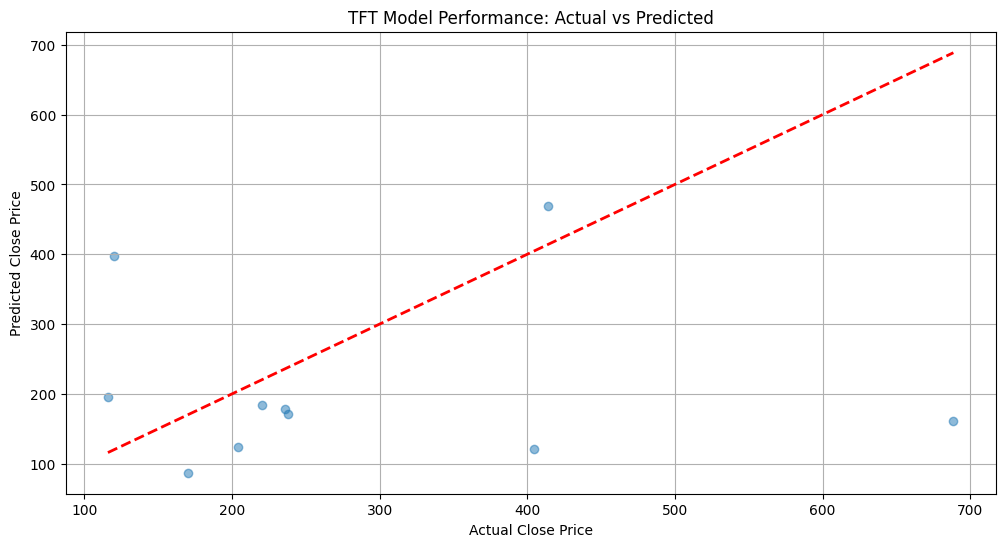

In [ ]:
# Visualize predictions vs actuals
plt.figure(figsize=(12, 6))
plt.scatter(pred_df['actual'], pred_df['prediction'], alpha=0.5)
plt.plot([pred_df['actual'].min(), pred_df['actual'].max()],
       [pred_df['actual'].min(), pred_df['actual'].max()],
       'r--', lw=2)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('TFT Model Performance: Actual vs Predicted')
plt.grid(True)
plt.savefig('tft_performance.png')
plt.show()

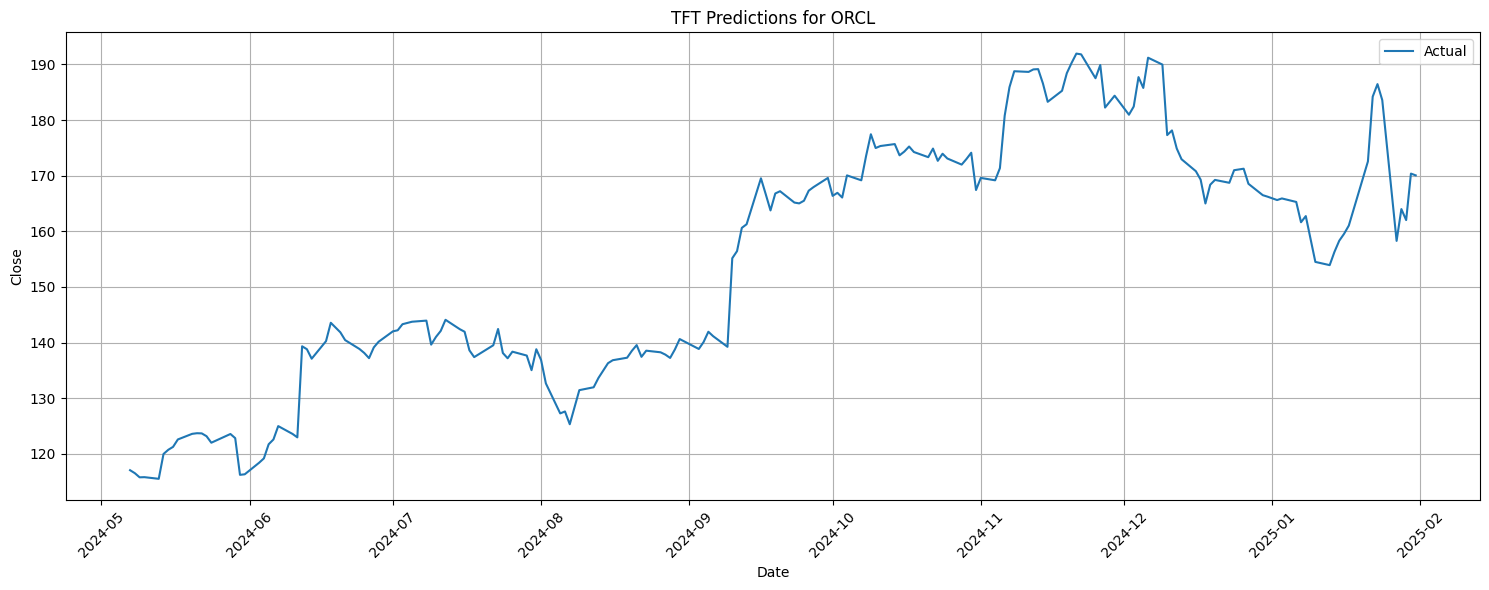

In [ ]:
# Visualize predictions vs actuals over time for a specific stock
ticker_to_plot = df_processed['Ticker'].unique()[0]  # Choose first ticker
ticker_val_data = df_processed[(df_processed['Ticker'] == ticker_to_plot) & (~df_processed['is_train'])].copy()

# Plot time series data for the selected ticker
if len(ticker_val_data) > 0:
    plt.figure(figsize=(15, 6))
    plt.plot(ticker_val_data['Date'], ticker_val_data[target], label='Actual')
    # You would add predictions here after matching them to dates
    plt.title(f'TFT Predictions for {ticker_to_plot}')
    plt.xlabel('Date')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'tft_predictions_{ticker_to_plot}.png')
    plt.show()

## Feature Importance

In [ ]:
# Get feature importance from the TFT model
importances = tft.interpret_output(val_dataloader, reduction="mean")

TypeError: 'DataLoader' object is not subscriptable

In [ ]:
# Variable importance
plt.figure(figsize=(10, 8))
order = importances.mean(dim=["variable", "observation"]).argsort(descending=True)
plt.imshow(importances.mean(dim="observation").index_select(0, order), aspect="auto")
plt.title("Feature Importance")
plt.ylabel("Feature")
plt.colorbar()
plt.savefig('tft_feature_importance.png')
plt.show()

## Saving Model

In [ ]:
# Save the trained model

torch.save(tft.state_dict(), "tft_stock_model.pth")
print("\nModel training and evaluation complete. Check the output directory for visualization plots.")

# TFT Rebuild

## Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE
import os
import warnings
from zipfile import ZipFile
from pytorch_forecasting.data.encoders import NaNLabelEncoder
warnings.filterwarnings('ignore')

## Configuration

In [ ]:
# Configuration
TICKER = 'MSFT'  # Choose ticker: 'AAPL', 'MSFT', 'GOOGL', etc.
TARGET = 'Target_1day'  # Choose target: 'Target_1day', 'Target_1week', 'Target_1month', 'Target_1year'
MAX_EPOCHS = 30

print(f"Processing data for {TICKER}, predicting {TARGET}")

Processing data for MSFT, predicting Target_1day


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


## Data Loading

In [ ]:
# Data Loading - Following teammate's approach
try:
    with ZipFile('_data.csv.zip', 'r') as z:
        with z.open('data.csv') as f:
            df = pd.read_csv(f, index_col=0)
except FileNotFoundError:
    cwd = os.getcwd()
    data_path = f'{cwd}/data/_data.csv.zip'
    with ZipFile(data_path, 'r') as z:
        with z.open('data.csv') as f:
            df = pd.read_csv(f, index_col=0)

# Filter for chosen ticker (if using single ticker approach)
if TICKER != 'ALL':
    df = df[df['Ticker'] == TICKER].copy()

# Convert date to datetime and ensure chronological order
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])  # Sort by Ticker first, then Date

# Forward fill financial data by ticker group
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
# Fill remaining features with zeros
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)
# Remove rows with critical missing data
df = df.dropna(subset=df.columns[0:-5])

# Load article sentiment data (if available)
try:
    csv_files = glob.glob(os.path.join("data", "*articles*.csv"))
    df_articles_list = []
    for file in csv_files:
        ticker = os.path.basename(file).split('_')[0]
        df_articles = pd.read_csv(file)
        df_articles['Ticker'] = ticker
        df_articles_list.append(df_articles)

    if df_articles_list:
        df_articles = pd.concat(df_articles_list, ignore_index=True)
        df_articles['Date'] = pd.to_datetime(df_articles['time'], errors='coerce', utc=True).dt.tz_convert(None).dt.date
        df_articles = df_articles[['Date', 'Ticker', 'sentiment']]

        # Process sentiment data
        sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
        df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
        df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
        df_articles['Date'] = pd.to_datetime(df_articles['Date'])

        # Calculate average sentiment
        df_articles['Articles_avg_sentiment'] = (
            (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) /
            (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
        )

        # Rename columns to avoid confusion
        df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral',
                               'Articles_Positive', 'Articles_avg_sentiment']

        # Merge with main data
        df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how='left')

    # Fill remaining NaNs in non-target columns
    df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)
except Exception as e:
    print(f"Could not load article data: {e}")

# Final sorting of data
df = df.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"\nTraining date range: {df['Date'].min()} to {df['Date'].max()}")


Dataset shape: (902, 817)

Training date range: 2021-06-30 00:00:00 to 2025-01-31 00:00:00


In [ ]:
# Filter for chosen ticker
df = df[df['Ticker'] == TICKER].copy()
print(f"Dataset shape for {TICKER}: {df.shape}")

# Convert date to datetime and ensure chronological order
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Basic data exploration
print("\nFirst few rows:")
print(df.head())

print("\nMissing values:")
missing_cols = df.isna().sum()
print(missing_cols[missing_cols > 0].sort_values(ascending=False).head(10))

print(f"\nTarget {TARGET} statistics:")
print(df[TARGET].describe())

Dataset shape for MSFT: (902, 817)

First few rows:
        Date        Open        High         Low       Close    Volume  \
0 2021-06-30  262.336071  262.985377  261.279713  262.539581  21656500   
1 2021-07-01  261.289382  263.450571  261.279710  263.217987  16725300   
2 2021-07-02  264.400313  269.420442  264.090182  269.081238  26458000   
3 2021-07-06  269.449488  270.748130  265.834592  269.090912  31565600   
4 2021-07-07  270.777221  272.027418  268.596660  271.290863  23260000   

   Dividends  Stock Splits  GDP (Billions USD)  Unemployment Rate (%)  ...  \
0        0.0           0.0           23368.861                    5.9  ...   
1        0.0           0.0           23921.991                    5.4  ...   
2        0.0           0.0           23921.991                    5.4  ...   
3        0.0           0.0           23921.991                    5.4  ...   
4        0.0           0.0           23921.991                    5.4  ...   

   emb_763  emb_764  emb_765  emb_

In [ ]:
# Create time index for TFT
df['time_idx'] = range(len(df))

# Create train/validation split with strict time separation
# Ensure validation set is recent but reasonable size
validation_size = min(60, int(len(df) * 0.15))  # Use 15% or 60 days, whichever is smaller
train_end_idx = len(df) - validation_size

# Flag rows as train or validation
df['is_train'] = True
df.iloc[train_end_idx:, df.columns.get_loc('is_train')] = False

print(f"\nTraining data: {df['is_train'].sum()} rows")
print(f"Validation data: {(~df['is_train']).sum()} rows")
print(f"\nTraining date range: {df[df['is_train']]['Date'].min()} to {df[df['is_train']]['Date'].max()}")
print(f"Validation date range: {df[~df['is_train']]['Date'].min()} to {df[~df['is_train']]['Date'].max()}")


Training data: 842 rows
Validation data: 60 rows

Training date range: 2021-06-30 00:00:00 to 2024-11-01 00:00:00
Validation date range: 2024-11-04 00:00:00 to 2025-01-31 00:00:00


## Data Cleaning

In [ ]:
# 1. Identify all target columns
target_cols = [col for col in df.columns if col.startswith('Target_')]

# 2. Fill non-target numerical columns
non_target_cols = [col for col in df.columns
                   if col not in target_cols
                   and col not in ['Date', 'Ticker', 'is_train', 'time_idx']]

# Forward fill within the ticker data (crucial for time series)
df[non_target_cols] = df[non_target_cols].ffill()

# Fill remaining NaNs with 0
df[non_target_cols] = df[non_target_cols].fillna(0)

# Fill target NaNs with 0
df[target_cols] = df[target_cols].fillna(0)

print("\nMissing values after filling:")
missing_cols = df.isna().sum()
print(missing_cols[missing_cols > 0].sort_values(ascending=False).head(10))


Missing values after filling:
Series([], dtype: int64)


In [ ]:
# Handle embedding columns with PCA
# 1. Identify embedding columns
emb_columns = [col for col in df.columns if col.startswith('emb_')]
print(f"\nFound {len(emb_columns)} embedding columns")

if len(emb_columns) > 0:
    # 2. Extract embedding data - CRITICAL: Only fit on training data
    emb_train_data = df.loc[df['is_train'], emb_columns].fillna(0)
    emb_test_data = df.loc[~df['is_train'], emb_columns].fillna(0)

    # 3. Apply PCA to reduce dimensionality - only first 10 components
    n_components = min(10, len(emb_columns), len(emb_train_data) - 1)
    print(f"Reducing {len(emb_columns)} embedding columns to {n_components} PCA components")

    # CRITICAL: Fit PCA only on training data to prevent leakage
    pca = PCA(n_components=n_components, random_state=42)
    emb_train_pca = pca.fit_transform(emb_train_data)
    emb_test_pca = pca.transform(emb_test_data)  # Only transform test data

    # Create dataframes with PCA components
    emb_train_pca_df = pd.DataFrame(
        emb_train_pca,
        columns=[f'emb_pca_{i}' for i in range(n_components)],
        index=df.loc[df['is_train']].index
    )
    emb_test_pca_df = pd.DataFrame(
        emb_test_pca,
        columns=[f'emb_pca_{i}' for i in range(n_components)],
        index=df.loc[~df['is_train']].index
    )

    # 4. Remove original embedding columns
    df = df.drop(columns=emb_columns)

    # 5. Add PCA components to dataframe
    for col in emb_train_pca_df.columns:
        df.loc[df['is_train'], col] = emb_train_pca_df[col].values
        df.loc[~df['is_train'], col] = emb_test_pca_df[col].values

    # Update feature list to include the new PCA columns
    emb_pca_cols = [f'emb_pca_{i}' for i in range(n_components)]
else:
    emb_pca_cols = []
    print("No embedding columns found")


Found 768 embedding columns
Reducing 768 embedding columns to 10 PCA components


## Model Configuration

In [ ]:
# Feature selection - Focus on most important features
# Basic financial data
basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Economic indicators
econ_cols = [col for col in df.columns if any(x in col for x in
             ['GDP', 'Unemployment Rate', 'Consumer', 'Producer', 'Retail', 'Housing'])]
econ_cols = econ_cols[:3] if len(econ_cols) > 3 else econ_cols

# Financial ratios
ratio_cols = [col for col in df.columns if any(x in col for x in
              ['ROA', 'Current_Ratio', 'EBITDA', 'Profit', 'Income'])]
ratio_cols = ratio_cols[:3] if len(ratio_cols) > 3 else ratio_cols

# Sentiment features
sentiment_cols = [col for col in df.columns if any(x in col for x in
                 ['vote', 'negative', 'neutral', 'positive'])]
sentiment_cols = sentiment_cols[:2] if len(sentiment_cols) > 2 else sentiment_cols

# Create final feature list
selected_features = basic_cols + econ_cols + ratio_cols + sentiment_cols + emb_pca_cols
selected_features = [f for f in selected_features if f in df.columns]
print(f"Using {len(selected_features)} selected features")

Using 23 selected features


In [ ]:
# Configure model parameters based on prediction target
if TARGET == 'Target_1day':
    max_prediction_length = 1
    max_encoder_length = 30
    hidden_size = 32
    attention_heads = 2
    dropout = 0.1
    learning_rate = 0.01
elif TARGET == 'Target_1week':
    max_prediction_length = 5
    max_encoder_length = 60
    hidden_size = 64
    attention_heads = 4
    dropout = 0.2
    learning_rate = 0.005
elif TARGET == 'Target_1month':
    max_prediction_length = 21
    max_encoder_length = 90
    hidden_size = 128
    attention_heads = 4
    dropout = 0.3
    learning_rate = 0.001
else:  # Target_1year
    max_prediction_length = 250
    max_encoder_length = 250
    hidden_size = 256
    attention_heads = 8
    dropout = 0.3
    learning_rate = 0.0005

In [ ]:
# Make sure encoder length doesn't exceed available training data
max_encoder_length = min(max_encoder_length,
                        len(df[df['is_train']]) - max_prediction_length)

print(f"\nModel Configuration:")
print(f"Prediction length: {max_prediction_length}")
print(f"Encoder length: {max_encoder_length}")
print(f"Hidden size: {hidden_size}")
print(f"Attention heads: {attention_heads}")
print(f"Dropout: {dropout}")
print(f"Learning rate: {learning_rate}")


Model Configuration:
Prediction length: 1
Encoder length: 30
Hidden size: 32
Attention heads: 2
Dropout: 0.1
Learning rate: 0.01


In [ ]:
# Create training dataset
training = TimeSeriesDataSet(
    data=df[df['is_train']],
    time_idx="time_idx",
    target=TARGET,
    group_ids=["Ticker"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=selected_features,
    target_normalizer=GroupNormalizer(
        groups=["Ticker"], transformation="softplus"
    ),
    categorical_encoders={
        "Ticker": NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [ ]:
# Create validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training, df[~df['is_train']], predict=True, stop_randomization=True
)

print(f"Training samples: {len(training)}")
print(f"Validation samples: {len(validation)}")

Training samples: 812
Validation samples: 1


In [ ]:
# Create dataloaders
batch_size = min(16, len(training))  # Ensure batch size isn't larger than dataset
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size,
                                         num_workers=0, shuffle=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size,
                                         num_workers=0, shuffle=False)

In [ ]:
# Set random seed for reproducibility
pl.seed_everything(42)

# Create TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_heads,
    dropout=dropout,
    hidden_continuous_size=hidden_size // 2,  # Half the hidden size
    loss=RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=5,
    optimizer="adamw"  # Often better than Adam
)

print(f"Model has {sum(p.numel() for p in tft.parameters() if p.requires_grad)} parameters")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Model has 121453 parameters


In [ ]:
# Configure early stopping and learning rate monitoring
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=True,
    mode="min"
)

lr_logger = pl.callbacks.LearningRateMonitor()

## Model Training

In [ ]:
# Configure trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='auto',  # Use GPU if available
    gradient_clip_val=0.1,
    # limit_train_batches=30,  # Uncommented to use full dataset for training
    callbacks=[early_stop_callback, lr_logger],
    enable_progress_bar=True
)

print("\nStarting model training...")
print(f"Maximum epochs: {MAX_EPOCHS}")

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Starting model training...
Maximum epochs: 30


In [ ]:
# Train model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

print(f"Training completed after {trainer.current_epoch + 1} epochs")
print(f"Best validation loss: {trainer.callback_metrics.get('val_loss', None)}")

INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2      | train
3  | prescalers                         | ModuleDict                      | 896    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 58.5 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.8 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.000
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Training completed after 12 epochs
Best validation loss: 0.0008592520607635379


## Model Evaluation

In [ ]:
# Make predictions
predictions = tft.predict(val_dataloader, return_y=True)

# Extract predictions and actual values
raw_predictions = predictions.output.detach().cpu().numpy()
raw_actuals = predictions.y[0].detach().cpu().numpy()

# Make sure dimensions align
if len(raw_predictions) != len(raw_actuals):
    min_len = min(len(raw_predictions), len(raw_actuals))
    raw_predictions = raw_predictions[:min_len]
    raw_actuals = raw_actuals[:min_len]

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Calculate metrics
mae = mean_absolute_error(raw_actuals, raw_predictions)
mse = mean_squared_error(raw_actuals, raw_predictions)
rmse = np.sqrt(mse)

# Calculate R² manually to avoid division by zero
y_mean = np.mean(raw_actuals)
ss_tot = np.sum((raw_actuals - y_mean) ** 2)
ss_res = np.sum((raw_actuals - raw_predictions) ** 2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0

print("\nModel Performance on Validation Data:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Model Performance on Validation Data:
MAE: 0.0009
MSE: 0.0000
RMSE: 0.0009
R²: 0.0000


## Data Visualization

In [ ]:
# Create DataFrame for visualization
val_dates = df.loc[~df['is_train'], 'Date'].values[:len(raw_actuals)]
pred_df = pd.DataFrame({
    'date': val_dates,
    'actual': raw_actuals.flatten(),
    'prediction': raw_predictions.flatten()
})

In [ ]:
# Calculate baseline models for comparison
# 1. Naive baseline (yesterday = today)
naive_baseline = df.loc[df['is_train'], TARGET].iloc[-len(raw_actuals):].values
if len(naive_baseline) < len(raw_actuals):
    # Pad with the last value if needed
    padding = np.full(len(raw_actuals) - len(naive_baseline), naive_baseline[-1])
    naive_baseline = np.concatenate([naive_baseline, padding])
naive_mae = mean_absolute_error(raw_actuals, naive_baseline)
naive_rmse = np.sqrt(mean_squared_error(raw_actuals, naive_baseline))

In [ ]:
# 2. Mean baseline
mean_baseline = np.full_like(raw_actuals, df.loc[df['is_train'], TARGET].mean())
mean_mae = mean_absolute_error(raw_actuals, mean_baseline)
mean_rmse = np.sqrt(mean_squared_error(raw_actuals, mean_baseline))

print("\nBaseline Comparisons:")
print(f"TFT Model: MAE={mae:.4f}, RMSE={rmse:.4f}")
print(f"Naive Baseline: MAE={naive_mae:.4f}, RMSE={naive_rmse:.4f}")
print(f"Mean Baseline: MAE={mean_mae:.4f}, RMSE={mean_rmse:.4f}")

if naive_mae > 0:
    print(f"Improvement over naive baseline: {(1 - mae/naive_mae) * 100:.2f}%")
if mean_mae > 0:
    print(f"Improvement over mean baseline: {(1 - mae/mean_mae) * 100:.2f}%")



Baseline Comparisons:
TFT Model: MAE=0.0009, RMSE=0.0009
Naive Baseline: MAE=1.9024, RMSE=1.9024
Mean Baseline: MAE=0.1714, RMSE=0.1714
Improvement over naive baseline: 99.95%
Improvement over mean baseline: 99.50%


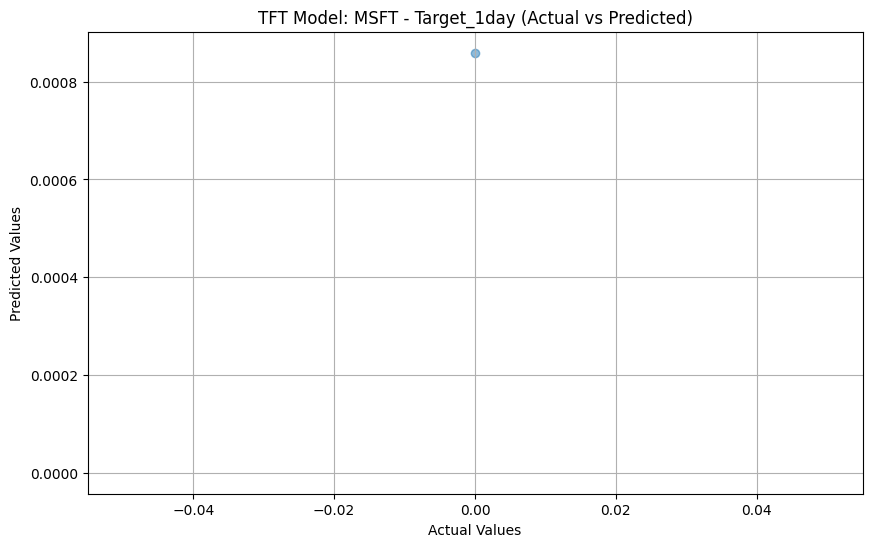

In [ ]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(pred_df['actual'], pred_df['prediction'], alpha=0.5)
plt.plot([pred_df['actual'].min(), pred_df['actual'].max()],
         [pred_df['actual'].min(), pred_df['actual'].max()],
         'r--', linewidth=2)
plt.title(f'TFT Model: {TICKER} - {TARGET} (Actual vs Predicted)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.savefig(f'tft_{TICKER}_{TARGET}_scatter.png')
plt.show()

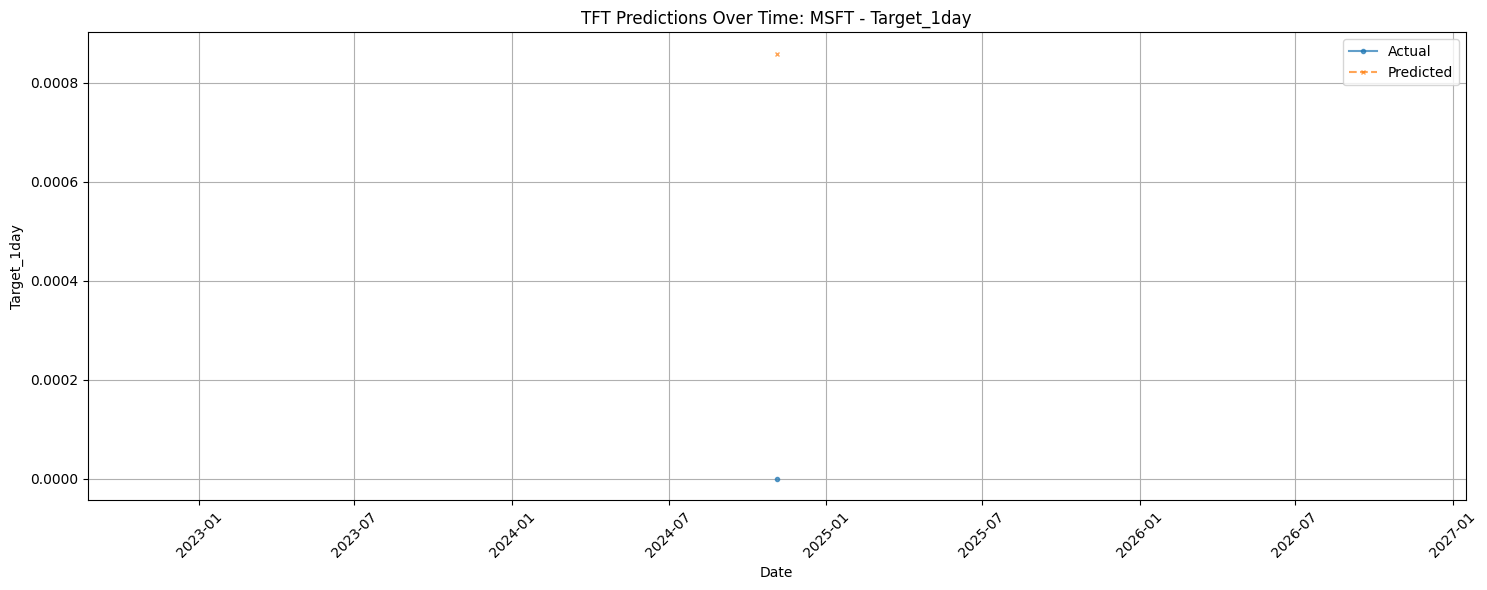

In [ ]:
# Time series plot
plt.figure(figsize=(15, 6))
plt.plot(pred_df['date'], pred_df['actual'], label='Actual', marker='o', alpha=0.7, markersize=3)
plt.plot(pred_df['date'], pred_df['prediction'], label='Predicted', marker='x', linestyle='--', alpha=0.7, markersize=3)
plt.title(f'TFT Predictions Over Time: {TICKER} - {TARGET}')
plt.xlabel('Date')
plt.ylabel(TARGET)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'tft_{TICKER}_{TARGET}_timeseries.png')
plt.show()

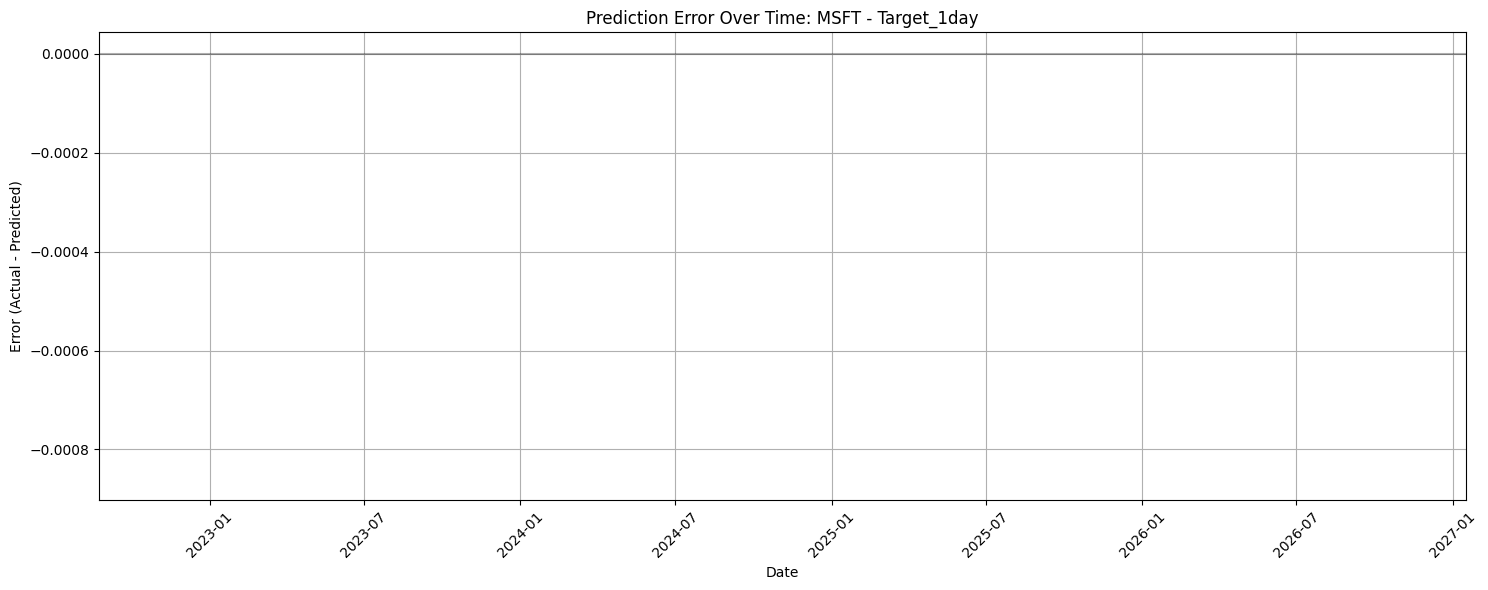

In [ ]:
# Error analysis
plt.figure(figsize=(15, 6))
pred_df['error'] = pred_df['actual'] - pred_df['prediction']
plt.plot(pred_df['date'], pred_df['error'], color='red')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title(f'Prediction Error Over Time: {TICKER} - {TARGET}')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'tft_{TICKER}_{TARGET}_error.png')
plt.show()

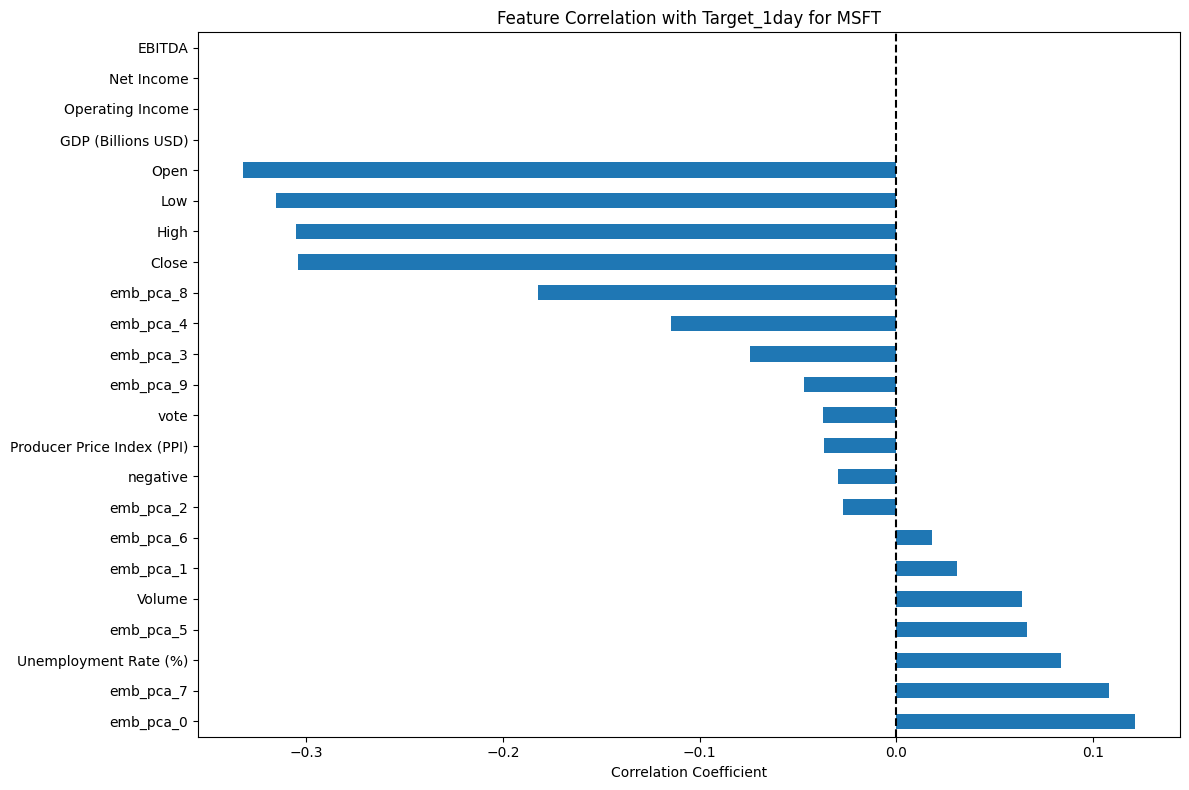

In [ ]:
# Feature importance using statistical correlation
feature_data = df[~df['is_train']][selected_features + [TARGET]]
correlations = feature_data.corr()[TARGET].drop(TARGET).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
correlations.plot(kind='barh')
plt.title(f'Feature Correlation with {TARGET} for {TICKER}')
plt.axvline(x=0, color='k', linestyle='--')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig(f'tft_{TICKER}_{TARGET}_feature_correlation.png')
plt.show()

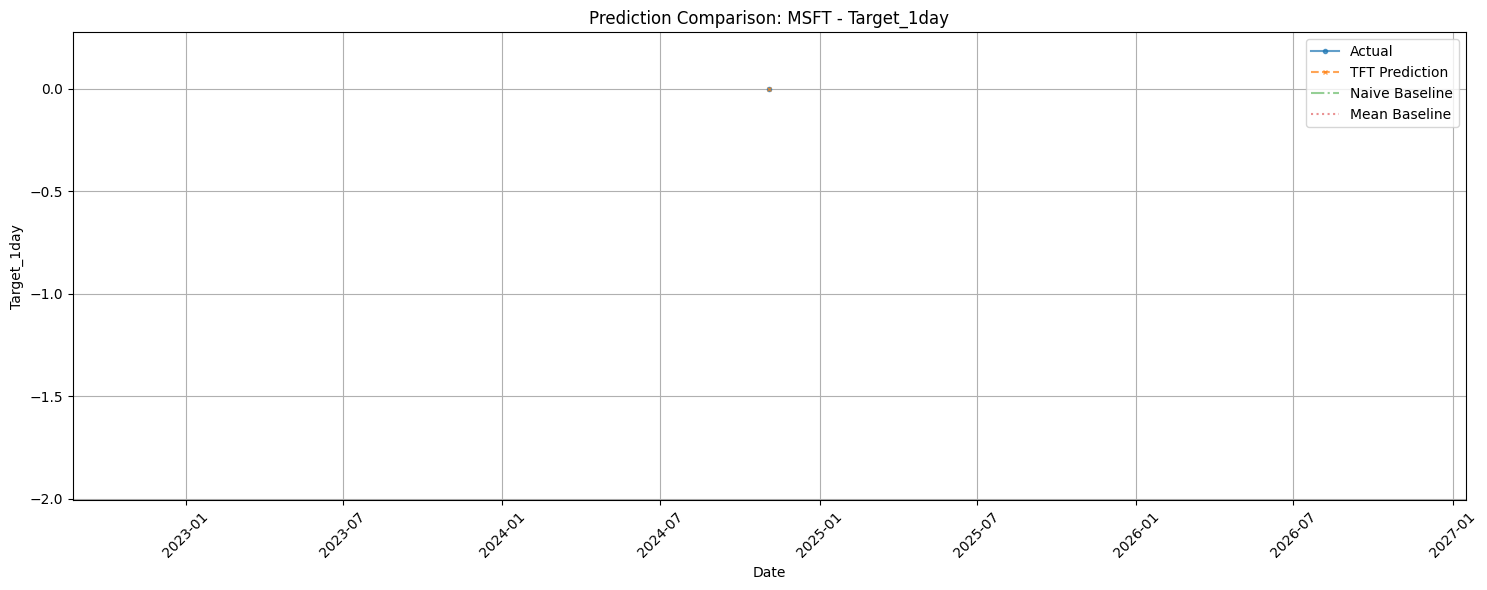

In [ ]:
# Prediction vs Actual with baselines
plt.figure(figsize=(15, 6))
plt.plot(pred_df['date'], pred_df['actual'], label='Actual', marker='o', alpha=0.7, markersize=3)
plt.plot(pred_df['date'], pred_df['prediction'], label='TFT Prediction', marker='x', linestyle='--', alpha=0.7, markersize=3)
plt.plot(pred_df['date'], naive_baseline[:len(pred_df)], label='Naive Baseline', linestyle='-.', alpha=0.5)
plt.plot(pred_df['date'], mean_baseline[:len(pred_df)], label='Mean Baseline', linestyle=':', alpha=0.5)
plt.title(f'Prediction Comparison: {TICKER} - {TARGET}')
plt.xlabel('Date')
plt.ylabel(TARGET)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'tft_{TICKER}_{TARGET}_comparison.png')
plt.show()

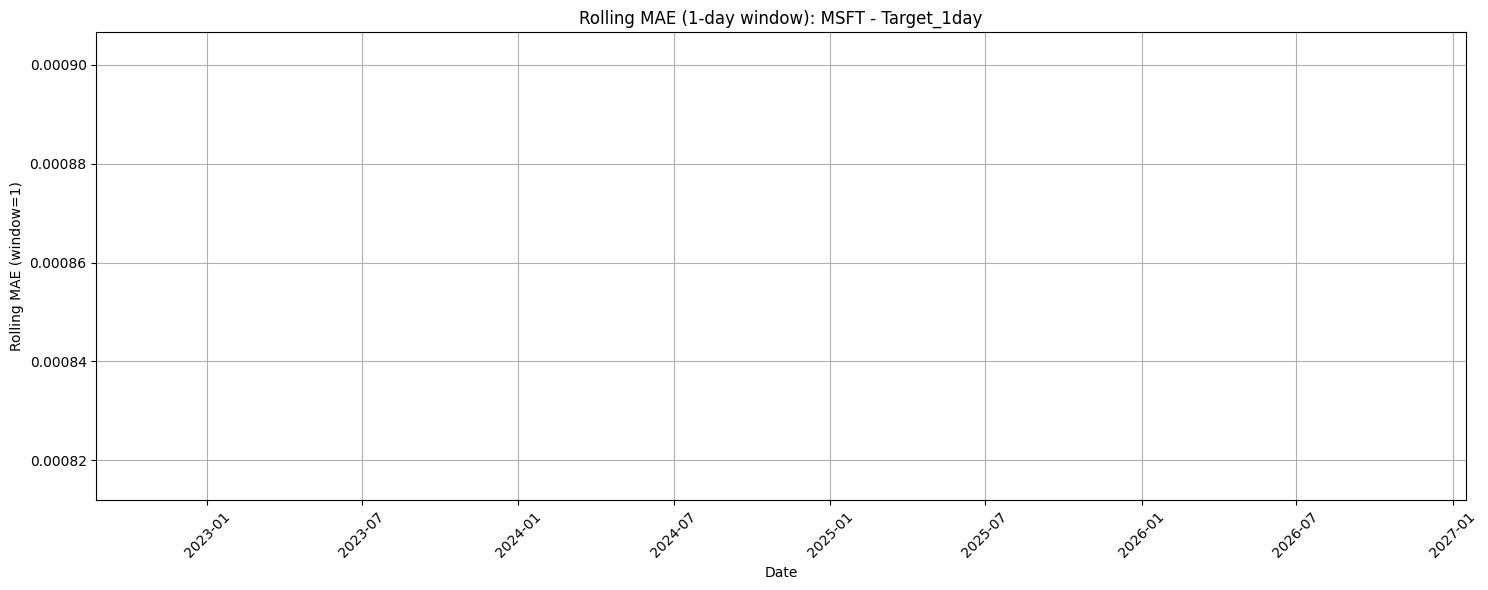

In [ ]:
# Rolling error analysis
window = min(5, len(pred_df))
pred_df['rolling_mae'] = abs(pred_df['error']).rolling(window=window, min_periods=1).mean()
plt.figure(figsize=(15, 6))
plt.plot(pred_df['date'], pred_df['rolling_mae'], color='purple')
plt.title(f'Rolling MAE ({window}-day window): {TICKER} - {TARGET}')
plt.xlabel('Date')
plt.ylabel(f'Rolling MAE (window={window})')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'tft_{TICKER}_{TARGET}_rolling_mae.png')
plt.show()

# Test

Processing data for MSFT, predicting Target_1day
Using CPU
Article loading error: No article files found
Dataset shape for MSFT: (902, 821)

First few rows:
        Date        Open        High         Low       Close    Volume  \
0 2021-06-30  262.336071  262.985377  261.279713  262.539581  21656500   
1 2021-07-01  261.289382  263.450571  261.279710  263.217987  16725300   
2 2021-07-02  264.400313  269.420442  264.090182  269.081238  26458000   
3 2021-07-06  269.449488  270.748130  265.834592  269.090912  31565600   
4 2021-07-07  270.777221  272.027418  268.596660  271.290863  23260000   

   Dividends  Stock Splits  GDP (Billions USD)  Unemployment Rate (%)  ...  \
0        0.0           0.0           23368.861                    5.9  ...   
1        0.0           0.0           23921.991                    5.4  ...   
2        0.0           0.0           23921.991                    5.4  ...   
3        0.0           0.0           23921.991                    5.4  ...   
4       

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training samples: 812
Validation samples: 1
Model has 121453 parameters

Starting model training...
Maximum epochs: 30


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2      | train
3  | prescalers                         | ModuleDict                      | 896    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.8 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 58.5 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.8 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 0.000
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training completed after 12 epochs
Best validation loss: 0.0008592520607635379

Model Performance on Validation Data:
MAE: 0.0009
MSE: 0.0000
RMSE: 0.0009
R²: 0.0000

Baseline Comparisons:
TFT Model: MAE=0.0009, RMSE=0.0009
Naive Baseline: MAE=1.9024, RMSE=1.9024
Mean Baseline: MAE=0.1714, RMSE=0.1714
Improvement over naive baseline: 99.95%
Improvement over mean baseline: 99.50%

Model saved as tft_MSFT_Target_1day_model.pth

Generating visualizations...


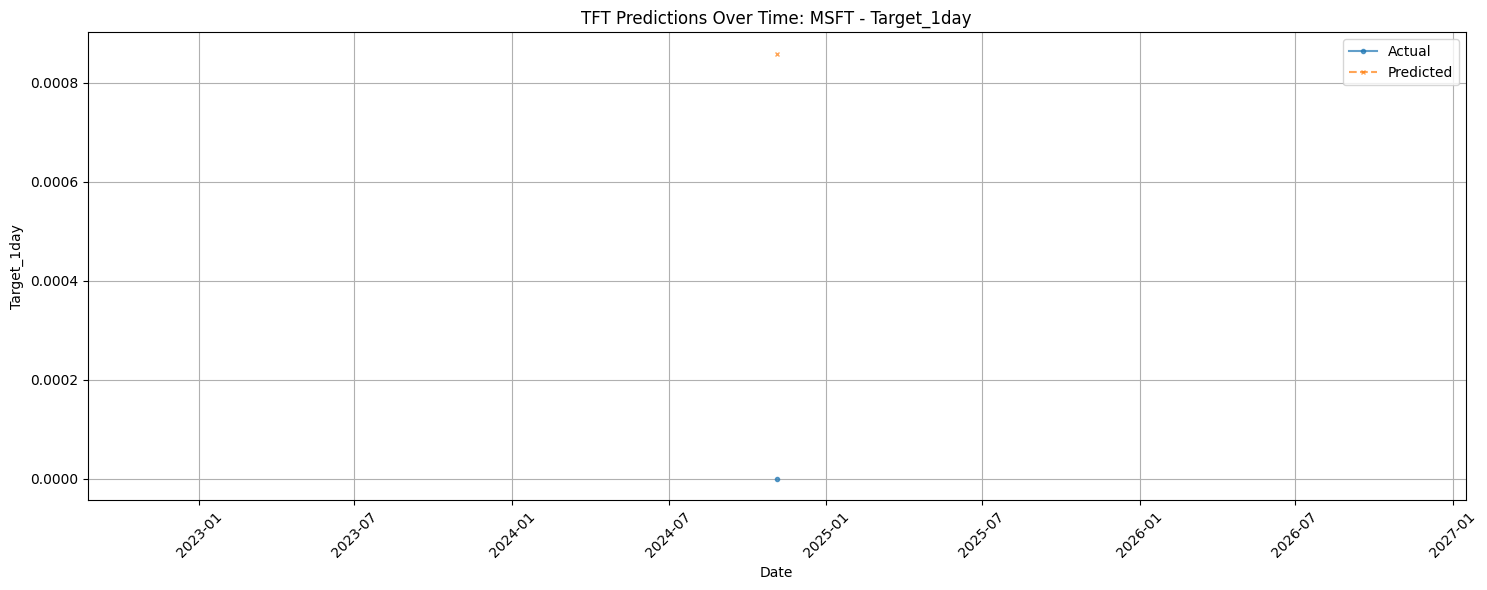

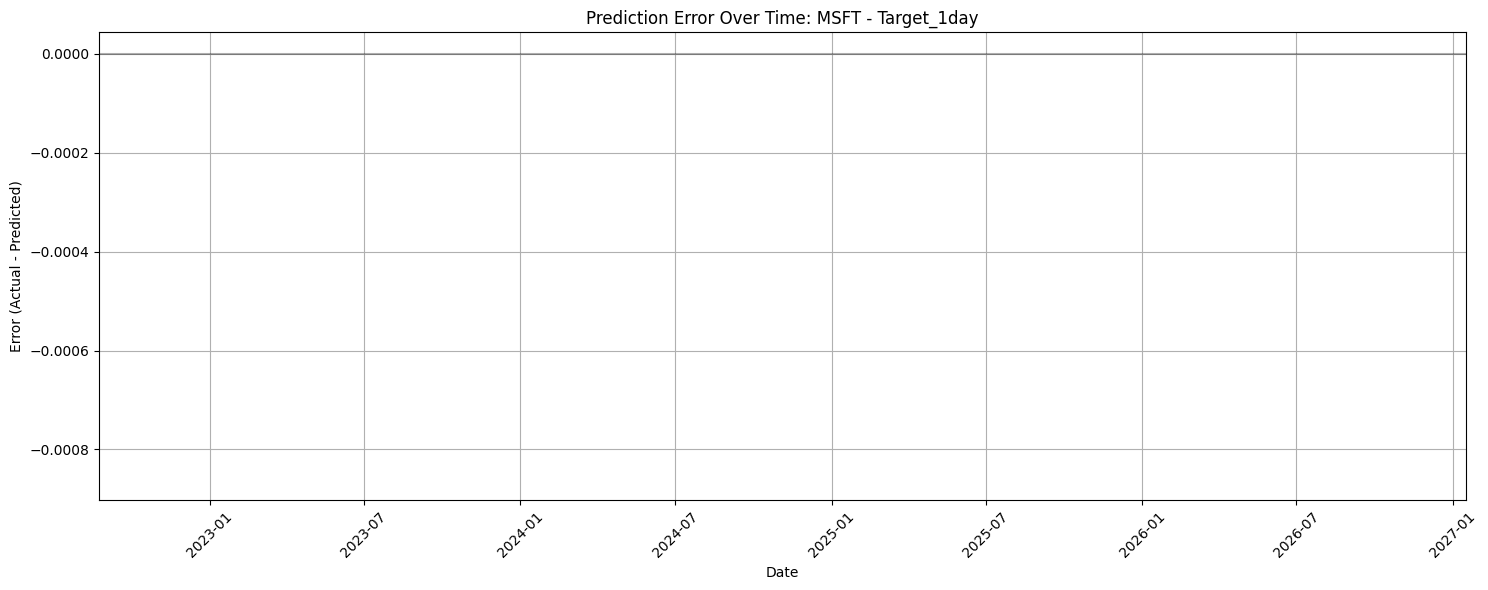

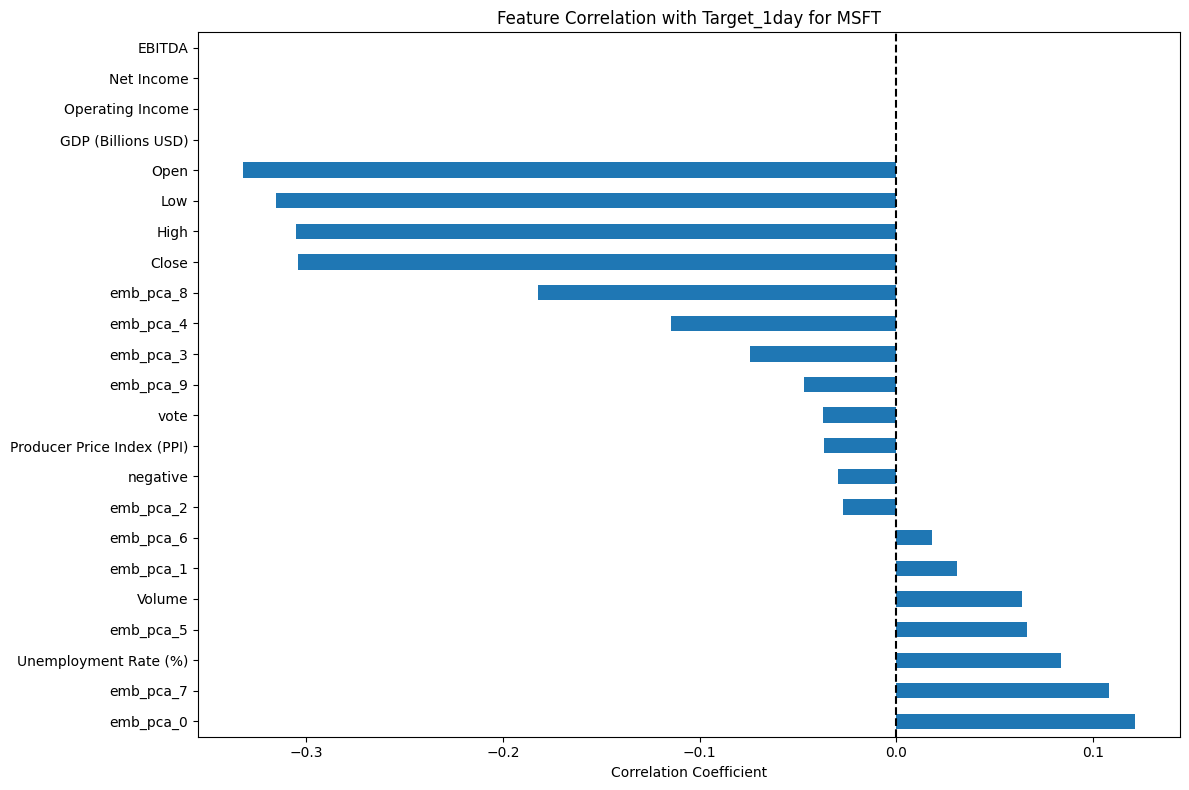

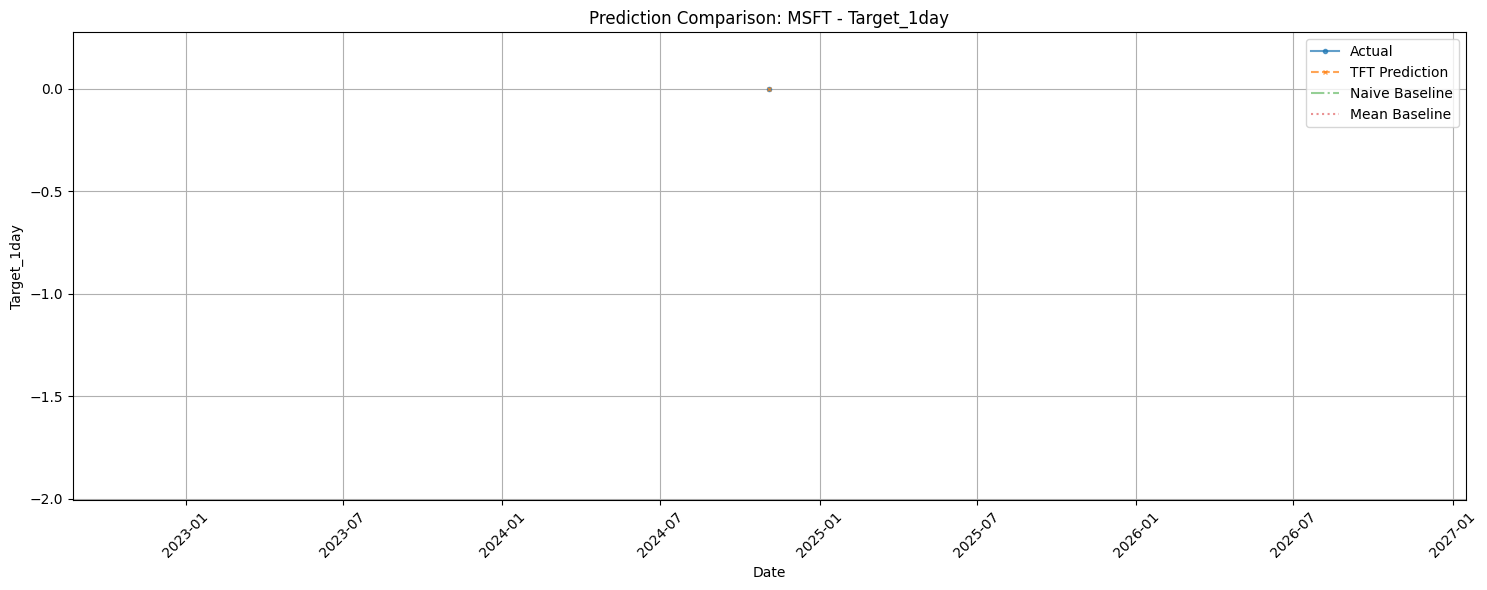


Analysis complete!


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from zipfile import ZipFile
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import warnings
warnings.filterwarnings('ignore')

import glob  # ← ADD THIS LINE


# Configuration
TICKER = 'MSFT'  # Choose ticker: 'AAPL', 'MSFT', 'GOOGL', etc.
TARGET = 'Target_1day'  # Choose target: 'Target_1day', 'Target_1week', 'Target_1month', 'Target_1year'
MAX_EPOCHS = 30
print(f"Processing data for {TICKER}, predicting {TARGET}")

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Data Loading - Using the correct approach to prevent data leakage
cwd = os.getcwd()
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

df['Date'] = pd.to_datetime(df['Date'])

# Fill missing values
df = df.sort_values(by=['Ticker', 'Date'])  # Sort by Ticker first for forward fill
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)
df = df.dropna(subset=df.columns[0:-5])

# Load article sentiment data (if available)
try:
    csv_files = glob.glob(os.path.join("data", "*articles*.csv"))
    if not csv_files:
        raise FileNotFoundError("No article files found")

    df_articles_list = []
    for file in csv_files:
        ticker = os.path.basename(file).split('_')[0]
        df_articles = pd.read_csv(file)
        df_articles['Ticker'] = ticker
        df_articles_list.append(df_articles)

    df_articles = pd.concat(df_articles_list, ignore_index=True)
    df_articles['Date'] = pd.to_datetime(df_articles['time'], errors='coerce', utc=True).dt.tz_convert(None).dt.date
    df_articles = df_articles[['Date', 'Ticker', 'sentiment']]

    # Process sentiment data with temporal safety
    sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
    df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
    df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
    df_articles['Date'] = pd.to_datetime(df_articles['Date'])

    # Calculate average sentiment safely
    denominator = df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive']
    df_articles['Articles_avg_sentiment'] = (
        (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) /
        denominator.mask(denominator == 0, 1)  # Prevent division by zero
    )

    # Merge with main data using existing dates
    existing_dates = df[['Date', 'Ticker']].drop_duplicates()
    df_articles = pd.merge(existing_dates, df_articles, on=['Date', 'Ticker'], how='left')

    # Fill missing sentiment values
    sentiment_cols = ['Articles_Negative', 'Articles_Neutral', 'Articles_Positive', 'Articles_avg_sentiment']
    df_articles[sentiment_cols] = df_articles[sentiment_cols].fillna(0)

    # Merge back to main dataframe
    df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how='left')

except Exception as e:
    print(f"Article loading error: {e}")
    # Ensure columns exist even if loading fails
    sentiment_cols = ['Articles_Negative', 'Articles_Neutral', 'Articles_Positive', 'Articles_avg_sentiment']
    for col in sentiment_cols:
        if col not in df.columns:
            df[col] = 0.0

df = df.sort_values(by=['Date', 'Ticker']).reset_index(drop=True)

# We'll skip lag features creation as TFT handles these automatically
# Filter for chosen ticker
df = df[df['Ticker'] == TICKER].copy()
print(f"Dataset shape for {TICKER}: {df.shape}")

# Basic data exploration
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
missing_cols = df.isna().sum()
print(missing_cols[missing_cols > 0].sort_values(ascending=False).head(10))
print(f"\nTarget {TARGET} statistics:")
print(df[TARGET].describe())

# Create time index for TFT
df['time_idx'] = range(len(df))

# Create train/validation split with strict time separation
validation_size = min(60, int(len(df) * 0.15))  # Use 15% or 60 days, whichever is smaller
train_end_idx = len(df) - validation_size

# Flag rows as train or validation
df['is_train'] = True
df.iloc[train_end_idx:, df.columns.get_loc('is_train')] = False
print(f"\nTraining data: {df['is_train'].sum()} rows")
print(f"Validation data: {(~df['is_train']).sum()} rows")
print(f"\nTraining date range: {df[df['is_train']]['Date'].min()} to {df[df['is_train']]['Date'].max()}")
print(f"Validation date range: {df[~df['is_train']]['Date'].min()} to {df[~df['is_train']]['Date'].max()}")

# 1. Identify all target columns
target_cols = [col for col in df.columns if col.startswith('Target_')]

# 2. Fill non-target numerical columns
non_target_cols = [col for col in df.columns
                   if col not in target_cols
                   and col not in ['Date', 'Ticker', 'is_train', 'time_idx']]

# Forward fill within the ticker data (crucial for time series)
df[non_target_cols] = df[non_target_cols].ffill()

# Fill remaining NaNs with 0
df[non_target_cols] = df[non_target_cols].fillna(0)

# Fill target NaNs with 0
df[target_cols] = df[target_cols].fillna(0)

# Handle embedding columns with PCA
# 1. Identify embedding columns
emb_columns = [col for col in df.columns if col.startswith('emb_')]
print(f"\nFound {len(emb_columns)} embedding columns")

if len(emb_columns) > 0:
    # 2. Extract embedding data - CRITICAL: Only fit on training data
    emb_train_data = df.loc[df['is_train'], emb_columns].fillna(0)
    emb_test_data = df.loc[~df['is_train'], emb_columns].fillna(0)

    # 3. Apply PCA to reduce dimensionality - only first 10 components
    n_components = min(10, len(emb_columns), len(emb_train_data) - 1)
    print(f"Reducing {len(emb_columns)} embedding columns to {n_components} PCA components")

    # CRITICAL: Fit PCA only on training data to prevent leakage
    pca = PCA(n_components=n_components, random_state=42)
    emb_train_pca = pca.fit_transform(emb_train_data)
    emb_test_pca = pca.transform(emb_test_data)  # Only transform test data

    # Create dataframes with PCA components
    emb_train_pca_df = pd.DataFrame(
        emb_train_pca,
        columns=[f'emb_pca_{i}' for i in range(n_components)],
        index=df.loc[df['is_train']].index
    )

    emb_test_pca_df = pd.DataFrame(
        emb_test_pca,
        columns=[f'emb_pca_{i}' for i in range(n_components)],
        index=df.loc[~df['is_train']].index
    )

    # 4. Remove original embedding columns
    df = df.drop(columns=emb_columns)

    # 5. Add PCA components to dataframe
    for col in emb_train_pca_df.columns:
        df.loc[df['is_train'], col] = emb_train_pca_df[col].values
        df.loc[~df['is_train'], col] = emb_test_pca_df[col].values

    # Update feature list to include the new PCA columns
    emb_pca_cols = [f'emb_pca_{i}' for i in range(n_components)]
else:
    emb_pca_cols = []
    print("No embedding columns found")

# Feature selection - Focus on most important features
# Basic financial data
basic_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Economic indicators
econ_cols = [col for col in df.columns if any(x in col for x in
            ['GDP', 'Unemployment Rate', 'Consumer', 'Producer', 'Retail', 'Housing'])]
econ_cols = econ_cols[:3] if len(econ_cols) > 3 else econ_cols

# Financial ratios
ratio_cols = [col for col in df.columns if any(x in col for x in
             ['ROA', 'Current_Ratio', 'EBITDA', 'Profit', 'Income'])]
ratio_cols = ratio_cols[:3] if len(ratio_cols) > 3 else ratio_cols

# Sentiment features
sentiment_cols = [col for col in df.columns if any(x in col for x in
                 ['vote', 'negative', 'neutral', 'positive'])]
sentiment_cols = sentiment_cols[:2] if len(sentiment_cols) > 2 else sentiment_cols

# Create final feature list
selected_features = basic_cols + econ_cols + ratio_cols + sentiment_cols + emb_pca_cols
selected_features = [f for f in selected_features if f in df.columns]
print(f"Using {len(selected_features)} selected features")

# Configure model parameters based on prediction target
if TARGET == 'Target_1day':
    max_prediction_length = 1
    max_encoder_length = 30
    hidden_size = 32
    attention_heads = 2
    dropout = 0.1
    learning_rate = 0.01
elif TARGET == 'Target_1week':
    max_prediction_length = 5
    max_encoder_length = 60
    hidden_size = 64
    attention_heads = 4
    dropout = 0.2
    learning_rate = 0.005
elif TARGET == 'Target_1month':
    max_prediction_length = 21
    max_encoder_length = 90
    hidden_size = 128
    attention_heads = 4
    dropout = 0.3
    learning_rate = 0.001
else:  # Target_1year
    max_prediction_length = 250
    max_encoder_length = 250
    hidden_size = 256
    attention_heads = 8
    dropout = 0.3
    learning_rate = 0.0005

# Make sure encoder length doesn't exceed available training data
max_encoder_length = min(max_encoder_length,
                       len(df[df['is_train']]) - max_prediction_length)

print(f"\nModel Configuration:")
print(f"Prediction length: {max_prediction_length}")
print(f"Encoder length: {max_encoder_length}")
print(f"Hidden size: {hidden_size}")
print(f"Attention heads: {attention_heads}")
print(f"Dropout: {dropout}")
print(f"Learning rate: {learning_rate}")

# Create training dataset
training = TimeSeriesDataSet(
    data=df[df['is_train']],
    time_idx="time_idx",
    target=TARGET,
    group_ids=["Ticker"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=selected_features,
    target_normalizer=GroupNormalizer(
        groups=["Ticker"], transformation="softplus"
    ),
    categorical_encoders={
        "Ticker": NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Create validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training, df[~df['is_train']], predict=True, stop_randomization=True
)

print(f"Training samples: {len(training)}")
print(f"Validation samples: {len(validation)}")

# Create dataloaders
batch_size = min(16, len(training))  # Ensure batch size isn't larger than dataset
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size,
                                        num_workers=0, shuffle=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size,
                                        num_workers=0, shuffle=False)

# Set random seed for reproducibility
pl.seed_everything(42)

# Create TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_heads,
    dropout=dropout,
    hidden_continuous_size=hidden_size // 2,  # Half the hidden size
    loss=RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=5,
    optimizer="adamw"  # Often better than Adam
)

print(f"Model has {sum(p.numel() for p in tft.parameters() if p.requires_grad)} parameters")

# Configure early stopping and learning rate monitoring
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=True,
    mode="min"
)

lr_logger = pl.callbacks.LearningRateMonitor()

# Configure trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='auto',  # Use GPU if available
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, lr_logger],
    enable_progress_bar=True
)

print("\nStarting model training...")
print(f"Maximum epochs: {MAX_EPOCHS}")

# Train model
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

print(f"Training completed after {trainer.current_epoch + 1} epochs")
print(f"Best validation loss: {trainer.callback_metrics.get('val_loss', None)}")

# Make predictions
predictions = tft.predict(val_dataloader, return_y=True)

# Extract predictions and actual values
raw_predictions = predictions.output.detach().cpu().numpy()
raw_actuals = predictions.y[0].detach().cpu().numpy()

# Make sure dimensions align
if len(raw_predictions) != len(raw_actuals):
    min_len = min(len(raw_predictions), len(raw_actuals))
    raw_predictions = raw_predictions[:min_len]
    raw_actuals = raw_actuals[:min_len]

# Calculate metrics
mae = mean_absolute_error(raw_actuals, raw_predictions)
mse = mean_squared_error(raw_actuals, raw_predictions)
rmse = np.sqrt(mse)

# Calculate R² manually to avoid division by zero
y_mean = np.mean(raw_actuals)
ss_tot = np.sum((raw_actuals - y_mean) ** 2)
ss_res = np.sum((raw_actuals - raw_predictions) ** 2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0

print("\nModel Performance on Validation Data:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Create DataFrame for visualization
val_dates = df.loc[~df['is_train'], 'Date'].values[:len(raw_actuals)]
pred_df = pd.DataFrame({
    'date': val_dates,
    'actual': raw_actuals.flatten(),
    'prediction': raw_predictions.flatten()
})

# Calculate baseline models for comparison
# 1. Naive baseline (yesterday = today)
naive_baseline = df.loc[df['is_train'], TARGET].iloc[-len(raw_actuals):].values
if len(naive_baseline) < len(raw_actuals):
    # Pad with the last value if needed
    padding = np.full(len(raw_actuals) - len(naive_baseline), naive_baseline[-1])
    naive_baseline = np.concatenate([naive_baseline, padding])

naive_mae = mean_absolute_error(raw_actuals, naive_baseline)
naive_rmse = np.sqrt(mean_squared_error(raw_actuals, naive_baseline))

# 2. Mean baseline
mean_baseline = np.full_like(raw_actuals, df.loc[df['is_train'], TARGET].mean())
mean_mae = mean_absolute_error(raw_actuals, mean_baseline)
mean_rmse = np.sqrt(mean_squared_error(raw_actuals, mean_baseline))

print("\nBaseline Comparisons:")
print(f"TFT Model: MAE={mae:.4f}, RMSE={rmse:.4f}")
print(f"Naive Baseline: MAE={naive_mae:.4f}, RMSE={naive_rmse:.4f}")
print(f"Mean Baseline: MAE={mean_mae:.4f}, RMSE={mean_rmse:.4f}")

if naive_mae > 0:
    print(f"Improvement over naive baseline: {(1 - mae/naive_mae) * 100:.2f}%")
if mean_mae > 0:
    print(f"Improvement over mean baseline: {(1 - mae/mean_mae) * 100:.2f}%")

# Save model for future use
torch.save(tft.state_dict(), f"tft_{TICKER}_{TARGET}_model.pth")
print(f"\nModel saved as tft_{TICKER}_{TARGET}_model.pth")

# Visualization functions
def plot_predictions_vs_actual():
    plt.figure(figsize=(15, 6))
    plt.plot(pred_df['date'], pred_df['actual'], label='Actual', marker='o', alpha=0.7, markersize=3)
    plt.plot(pred_df['date'], pred_df['prediction'], label='Predicted', marker='x',
             linestyle='--', alpha=0.7, markersize=3)
    plt.title(f'TFT Predictions Over Time: {TICKER} - {TARGET}')
    plt.xlabel('Date')
    plt.ylabel(TARGET)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'tft_{TICKER}_{TARGET}_timeseries.png')
    plt.show()

def plot_error_analysis():
    plt.figure(figsize=(15, 6))
    pred_df['error'] = pred_df['actual'] - pred_df['prediction']
    plt.plot(pred_df['date'], pred_df['error'], color='red')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Prediction Error Over Time: {TICKER} - {TARGET}')
    plt.xlabel('Date')
    plt.ylabel('Error (Actual - Predicted)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'tft_{TICKER}_{TARGET}_error.png')
    plt.show()

def plot_feature_importance():
    # Feature importance using statistical correlation
    feature_data = df[~df['is_train']][selected_features + [TARGET]]
    correlations = feature_data.corr()[TARGET].drop(TARGET).sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    correlations.plot(kind='barh')
    plt.title(f'Feature Correlation with {TARGET} for {TICKER}')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.savefig(f'tft_{TICKER}_{TARGET}_feature_correlation.png')
    plt.show()

def plot_model_comparison():
    plt.figure(figsize=(15, 6))
    plt.plot(pred_df['date'], pred_df['actual'], label='Actual', marker='o', alpha=0.7, markersize=3)
    plt.plot(pred_df['date'], pred_df['prediction'], label='TFT Prediction',
             marker='x', linestyle='--', alpha=0.7, markersize=3)
    plt.plot(pred_df['date'], naive_baseline[:len(pred_df)], label='Naive Baseline',
             linestyle='-.', alpha=0.5)
    plt.plot(pred_df['date'], mean_baseline[:len(pred_df)], label='Mean Baseline',
             linestyle=':', alpha=0.5)
    plt.title(f'Prediction Comparison: {TICKER} - {TARGET}')
    plt.xlabel('Date')
    plt.ylabel(TARGET)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'tft_{TICKER}_{TARGET}_comparison.png')
    plt.show()

# Generate visualizations
print("\nGenerating visualizations...")
plot_predictions_vs_actual()
plot_error_analysis()
plot_feature_importance()
plot_model_comparison()

print("\nAnalysis complete!")